In [25]:
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,f1_score,roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

In [18]:
df_train=pd.read_csv("../../data/clean/HealthInspectionBalancedTrain.csv")
df_test=pd.read_csv("../../data/clean/HealthInspectionTest.csv")
df_val   = pd.read_csv("../../data/clean/HealthInspectionVal.csv")
# print(df_test.columns)
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(25909, 38)
(6041, 38)
(9147, 38)


## Split into Test and Training sets

In [19]:
TARGET = "failFlag"   # CHANGE if needed

X_train = df_train.drop(columns=[TARGET])
y_train = df_train[TARGET]

X_val = df_val.drop(columns=[TARGET])
y_val = df_val[TARGET]

X_test = df_test.drop(columns=[TARGET])
y_test = df_test[TARGET]


In [21]:

print(y_train.value_counts(normalize=True))

failFlag
0.0    0.601181
1.0    0.398819
Name: proportion, dtype: float64


## Model defination including class imbalance
here the dataset is highly imbalanced showing no light on minority classes

In [22]:
# rf = RandomForestClassifier(
#     n_estimators=500, #number of trees, more trees usually betterbut slow
#     max_depth=None, #can be gievn a number but lets give it to decide stopped by min sample leaf
#     min_samples_leaf=5,#min samples per leaf to prevent overfitting
#     # class_weight="balanced", 
#     random_state=42,
#     n_jobs=-1#cpu core
# )

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
#if not good balance use smote or random oversampler for training set

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [23]:
y_val_pred = rf.predict(X_val)
y_val_proba = rf.predict_proba(X_val)[:, 1]


In [26]:
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))
print("F1:", f1_score(y_val, y_val_pred))
print("ROC AUC:", roc_auc_score(y_val, y_val_proba))

print("\nClassification Report:\n")
print(classification_report(y_val, y_val_pred))

Accuracy: 0.6489559418388543
Precision: 0.05797587131367292
Recall: 0.3019197207678883
F1: 0.0972729828507169
ROC AUC: 0.5260775606759508

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.67      0.78      8574
           1       0.06      0.30      0.10       573

    accuracy                           0.65      9147
   macro avg       0.50      0.49      0.44      9147
weighted avg       0.88      0.65      0.74      9147



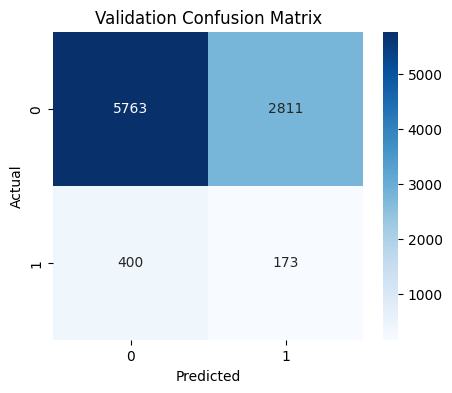

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Validation Confusion Matrix")
plt.show()


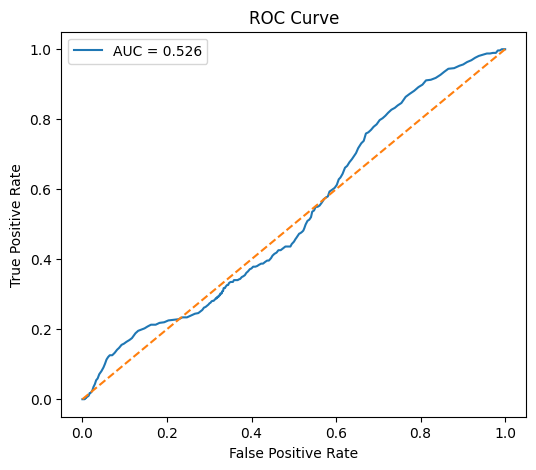

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_val, y_val_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_val, y_val_proba):.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


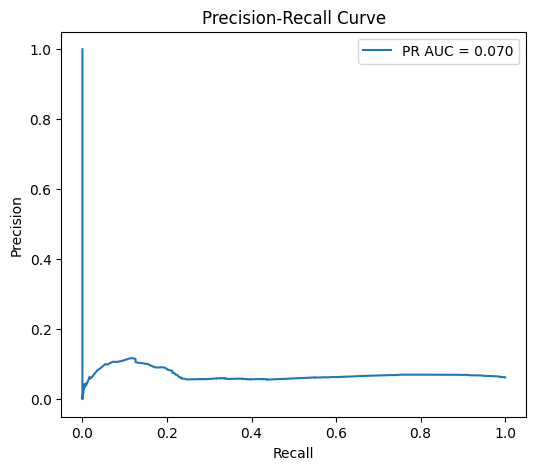

In [29]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_val, y_val_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR AUC = {average_precision_score(y_val, y_val_proba):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


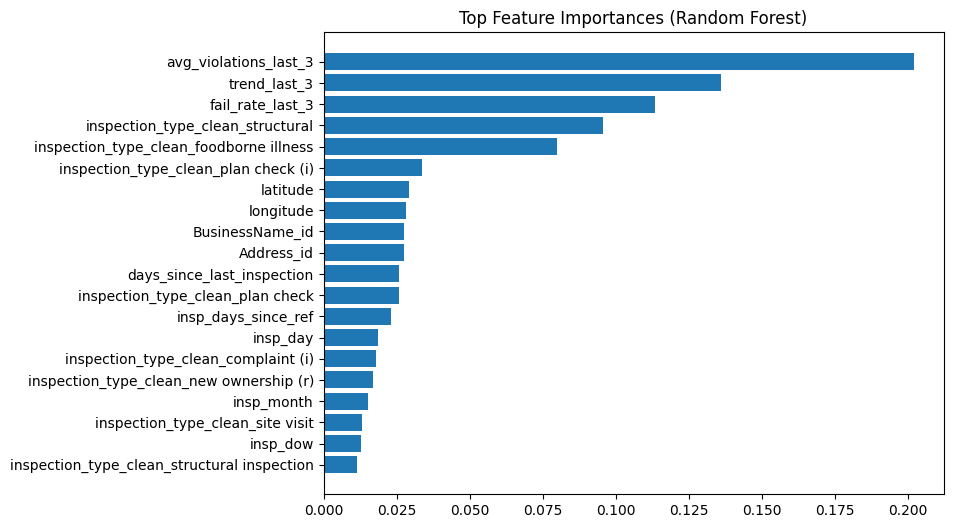

In [30]:
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 20
plt.figure(figsize=(8,6))
plt.barh(
    X_train.columns[indices][:top_n][::-1],
    importances[indices][:top_n][::-1]
)
plt.title("Top Feature Importances (Random Forest)")
plt.show()


In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"]
}

rf_base = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

grid = GridSearchCV(
    rf_base,
    param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
print("Best Params:", grid.best_params_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Params: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}


In [32]:
y_val_pred = best_rf.predict(X_val)
y_val_proba = best_rf.predict_proba(X_val)[:, 1]

print("F1:", f1_score(y_val, y_val_pred))
print("ROC AUC:", roc_auc_score(y_val, y_val_proba))


F1: 0.09480296973158195
ROC AUC: 0.5342089054493657


In [33]:
y_test_pred = best_rf.predict(X_test)
y_test_proba = best_rf.predict_proba(X_test)[:, 1]

print("TEST RESULTS")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))
print("ROC AUC:", roc_auc_score(y_test, y_test_proba))


TEST RESULTS
Accuracy: 0.4767422612150306
Precision: 0.06619018023617154
Recall: 0.5772357723577236
F1: 0.11876219682185671
ROC AUC: 0.5585424621876685


In [34]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_rf = CalibratedClassifierCV(
    best_rf,
    method="isotonic",
    cv=5
)

calibrated_rf.fit(X_train, y_train)

y_test_cal_proba = calibrated_rf.predict_proba(X_test)[:, 1]
print("Calibrated ROC AUC:", roc_auc_score(y_test, y_test_cal_proba))


Calibrated ROC AUC: 0.5447264363334748


In [35]:
import numpy as np

thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = []

for t in thresholds:
    preds = (y_val_proba >= t).astype(int)
    f1_scores.append(f1_score(y_val, preds))

best_t = thresholds[np.argmax(f1_scores)]
print("Best Threshold:", best_t)


Best Threshold: 0.1326530612244898


In [14]:
failppb=rf.predict_proba(X_test)[:, 1]#this gives fail probabilty, its ppb high it will be 1 else 0
failppb.min(), failppb.max(), failppb.mean()

(np.float64(0.031156917885648748),
 np.float64(0.9151270505164532),
 np.float64(0.4435951505940158))

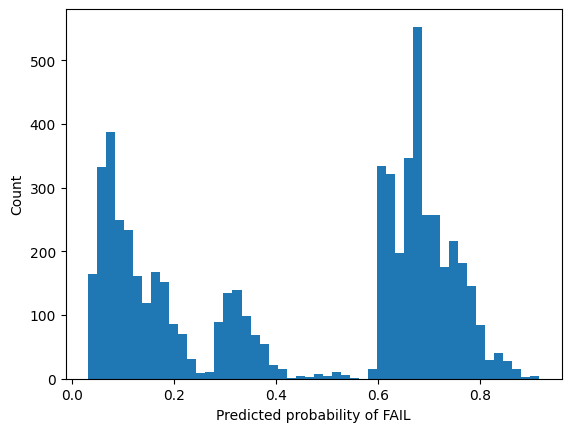

In [15]:

plt.hist(failppb, bins=50)
plt.xlabel("Predicted probability of FAIL")
plt.ylabel("Count")
plt.show()

In [16]:
y_proba = rf.predict_proba(X_test)[:, 1]
# y_pred = (y_proba >= 0.4).astype(int) #0.5 is bad for imbalanced data

best_f1 = 0
best_thresh = 0.5
for t in np.arange(0.05, 0.95, 0.05):
    y_pred_temp = (y_proba >= t).astype(int)
    score = f1_score(y_test, y_pred_temp, average="macro")
    if score > best_f1:
        best_f1 = score
        best_thresh = t
        best_y_pred = y_pred_temp

print("Best threshold:", best_thresh, "Best F1:", best_f1)

y_pred = best_y_pred
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))



Best threshold: 0.7500000000000001 Best F1: 0.5346752120133416
[[5148  524]
 [ 300   69]]
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      5672
           1       0.12      0.19      0.14       369

    accuracy                           0.86      6041
   macro avg       0.53      0.55      0.53      6041
weighted avg       0.89      0.86      0.88      6041

ROC AUC: 0.560197289208435


In [31]:
y_test.value_counts(normalize=True)

failFlag
0    0.921151
1    0.078849
Name: proportion, dtype: float64

In [38]:
test_df=test.copy()
test_df["predicted_fail"] = y_pred
test_df["predicted_proba"] = y_proba
test_df["predicted_risk"]=(test_df["predicted_proba"] >= 0.35).astype(int)

test_df["Predicted Risk"] = test_df["predicted_risk"].map({
    1: "High Risk",
    0: "Low Risk"
})


In [26]:
latest_business_df = (
    test_df
    .sort_values("inspection_date")
    .groupby(["BusinessName", "Address"])
    .tail(1)
)
latest_business_df.to_csv("../../data/processed/Latest_Business_Risk_Predictions.csv", index=False)

In [39]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[8867    0]
 [ 759    0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      8867
           1       0.00      0.00      0.00       759

    accuracy                           0.92      9626
   macro avg       0.46      0.50      0.48      9626
weighted avg       0.85      0.92      0.88      9626



C:\Users\lkneh\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\lkneh\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\lkneh\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

In [15]:
importances = pd.Series(
    rf.feature_importances_,
    index=FEATURES
).sort_values(ascending=False)

# importances.plot.bar(figsize=(10,6), title="Feature Importances")

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [17]:
rf_base = RandomForestClassifier(
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)

In [18]:
param_dist = {
    "n_estimators": randint(200, 800),
    "max_depth": [None, 8, 12, 16, 20],
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 20),
    "max_features": ["sqrt", "log2", 0.5]
}

In [19]:
rf_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist,
    n_iter=40,
    scoring="roc_auc",      # or "f1_macro"
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [20]:
rf_search.fit(X_train, y_train)
print(rf_search.best_params_)
rf_best = rf_search.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 12, 'n_estimators': 271}


In [21]:
y_proba = rf_best.predict_proba(X_test)[:, 1]
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))

# search best threshold for macro F1
best_f1 = 0
best_thresh = 0.5
for t in np.arange(0.05, 0.95, 0.05):
    y_pred_temp = (y_proba >= t).astype(int)
    score = f1_score(y_test, y_pred_temp, average="macro")
    if score > best_f1:
        best_f1 = score
        best_thresh = t
        best_y_pred = y_pred_temp

print("Best threshold:", best_thresh, "Best macro F1:", best_f1)
print(confusion_matrix(y_test, best_y_pred))
print(classification_report(y_test, best_y_pred))

Test ROC AUC: 0.6815042169801635
Best threshold: 0.55 Best macro F1: 0.5663277824836407
[[7826 1041]
 [ 532  227]]
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      8867
           1       0.18      0.30      0.22       759

    accuracy                           0.84      9626
   macro avg       0.56      0.59      0.57      9626
weighted avg       0.88      0.84      0.85      9626

